In [1]:
#!~/new_python_3_11_env/bin/python3 -m pip install tensorflow-datasets
#!~/new_python_3_11_env/bin/python3 -m pip install tensorflow

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import keras
import random
import numpy as np
import matplotlib.pyplot as plt

2025-01-15 19:45:06.878577: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-15 19:45:06.999765: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-15 19:45:08.041852: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-01-15 19:45:08.041912

In [3]:
# Load original model
original_model_base = tf.keras.models.load_model('CNNModel/BaseCNN.keras')  # Replace with your model file
original_model_base.trainable = False  # Freeze weights
original_model_strong = tf.keras.models.load_model('CNNModel/StrongCNN.keras')  # Replace with your model file
original_model_strong.trainable = False  # Freeze weights
original_model_simple = tf.keras.models.load_model('CNNModel/simpleCNN.keras')  # Replace with your model file


original_model_simple.trainabl=False

original_model = tf.keras.models.load_model('CNNModel/BaseCNN.keras')  # Replace with your model file
original_model.trainable = False  # Freeze weights



2025-01-15 19:45:14.478069: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15948 MB memory:  -> device: 0, name: NVIDIA A10, pci bus id: 0000:17:00.0, compute capability: 8.6
2025-01-15 19:45:14.480575: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 3 MB memory:  -> device: 1, name: NVIDIA A10, pci bus id: 0000:ca:00.0, compute capability: 8.6


In [4]:
# @ layers with 2 deconvolution layers
def build_atn(input_shape):
    model = tf.keras.Sequential([
        # First convolutional layers to capture features
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),  # Downsample (14, 14, 64)

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),  # Downsample (7, 7, 128)

        # Fully connected layer to integrate features
        layers.Flatten(),  # Flatten to shape (7 * 7 * 128 = 6272)
        layers.Dense(6272, activation='relu'),  # Match the reshape target

        # Deconvolution layers to reconstruct adversarial examples
        layers.Reshape((7, 7, 128)),  # Reshape for deconvolution
        layers.Conv2DTranspose(128, (3, 3), activation='relu', strides=2, padding='same'),  # (14, 14, 128)
        layers.Conv2DTranspose(64, (3, 3), activation='relu', strides=2, padding='same'),  # (28, 28, 64)
        
        layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same'),  # Output layer (28, 28, 1)
        layers.Lambda(lambda x: x * 255)  # Scale to [0, 255]
    ])
    return model

# Build the ATN
input_shape = (28, 28, 1)  # MNIST dataset shape
atn = build_atn(input_shape)


In [5]:
# Define ATN 2 Layers only convulution
###
'''
def build_atn(input_shape):
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(np.prod(input_shape), activation='sigmoid'),  # Use sigmoid for range [0, 1]
        layers.Reshape(input_shape),
        layers.Lambda(lambda x: x * 255)  # Scale to [0, 255]
    ])
    return model


input_shape = (28, 28, 1)  # Assuming MNIST dataset
atn = build_atn(input_shape)
'''

"\ndef build_atn(input_shape):\n    model = tf.keras.Sequential([\n        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),\n        layers.MaxPooling2D((2, 2)),\n        layers.Conv2D(64, (3, 3), activation='relu'),\n        layers.Flatten(),\n        layers.Dense(128, activation='relu'),\n        layers.Dense(np.prod(input_shape), activation='sigmoid'),  # Use sigmoid for range [0, 1]\n        layers.Reshape(input_shape),\n        layers.Lambda(lambda x: x * 255)  # Scale to [0, 255]\n    ])\n    return model\n\n\ninput_shape = (28, 28, 1)  # Assuming MNIST dataset\natn = build_atn(input_shape)\n"

In [6]:
# Define input loss and output loss function
def input_loss(x, x_prime):
    return tf.reduce_mean(tf.square(tf.cast(x, tf.float32) - x_prime))  # Cast x to float32  # L2 loss

def output_loss(y_pred, y_target):
    return tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_target, y_pred)) # crossentropy



In [7]:
def get_second_highest_target(y_pred_original):
    # Sort predictions to find the highest and second-highest indices
    top_2_indices = tf.argsort(y_pred_original, direction='DESCENDING', axis=1)[:, :2]
    second_highest_indices = top_2_indices[:, 1]

    # Create one-hot encoding for the second-highest class
    y_target = tf.one_hot(second_highest_indices, depth=y_pred_original.shape[1])
    return y_target


In [8]:
class RandomApply(tf.keras.layers.Layer):
    def __init__(self, layer, p=0.5, **kwargs):
        super().__init__(**kwargs)
        self.layer = layer
        self.p = p

    def call(self, x, training=None):
        if not training:
            return x
        return tf.cond(
            tf.random.uniform(()) < self.p,
            lambda: self.layer(x, training=training),
            lambda: x
        )

# A simple pipeline: horizontal flip, random rotation
data_augmentation = tf.keras.Sequential([
    RandomApply(layers.RandomRotation(0.2), p=0.5),
    RandomApply(layers.RandomZoom(0.1,fill_mode='nearest'), p=0.5),
])
augmentation_with_p = RandomApply(data_augmentation, p=0)


In [9]:
# Define learning rate schedule
boundaries = [20000,100000]  # Steps at which learning rate changes
values = [0.01,0.001, 0.0001]  # Corresponding learning rates

lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=boundaries,
    values=values
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

beta = 0.1  # Weight for input-space loss
models = [original_model_base, original_model_strong, original_model_simple]

@tf.function

def train_step(x, y_original, selected_model):
    with tf.GradientTape() as tape:
        # Generate adversarial examples
        x_prime = atn(x)

        # Get predictions for original and adversarial inputs using the selected model
        y_pred_original = selected_model(x, training=False)
        y_pred = selected_model(x_prime, training=False)

        # Compute the second-highest target dynamically
        y_target = get_second_highest_target(y_pred_original)

        # Compute input loss and output loss separately
        l_x = input_loss(x, x_prime)
        l_y = output_loss(y_pred , y_target )

        # Compute the combined loss
        loss = beta * l_x + l_y

    # Compute and apply gradients
    gradients = tape.gradient(loss, atn.trainable_variables)
    optimizer.apply_gradients(zip(gradients, atn.trainable_variables))

    # Return total loss, input loss, and output loss
    return loss, l_x, l_y

In [10]:
# Load MNIST datasetatn
mnist_train, mnist_test = tfds.load('mnist', split=['train', 'test'], as_supervised=True)

# Function to create adversarial target labels
#def create_adversarial_target(label):
#    # Example: Shift each label by 1 (cyclic mapping)
#    return (label + 1) % 10

# Preprocessing function for training the ATN
def preprocess_image_atn(image, label):
    # Do NOT normalize the images; keep them in the range [0, 255]
    image = tf.cast(image, tf.float32)  # Ensure float32 for compatibility with loss functions
    label_one_hot = tf.one_hot(label, depth=10)  # One-hot encode the original label
    
    # Return only the raw image and the original label
    return image, label_one_hot

# Apply preprocessing to the dataset
mnist_train_atn = mnist_train.map(preprocess_image_atn)
mnist_test_atn = mnist_test.map(preprocess_image_atn)

# Batch and prefetch the dataset
batch_size = 32
mnist_train_atn = mnist_train_atn.batch(batch_size).prefetch(tf.data.AUTOTUNE)
mnist_test_atn = mnist_test_atn.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("Dataset loaded without normalization.")


Dataset loaded without normalization.


In [11]:
from tqdm import tqdm
import time

# Training parameters
epochs = 120
batch_size = 32
epoch_losses = []
epoch_input_losses = []
epoch_output_losses = []
epoch_models = []  # To store the name of the selected model
print(f"{'Epoch':<8}{'Total Loss':<12}{'Scaled Input Loss':<12}{'Output Loss':<12}{'Time (s)':<10}")
print("-" * 50)

for epoch in range(epochs):
    start_time = time.time()
    epoch_loss = 0
    epoch_input_loss = 0
    epoch_output_loss = 0
    batch_count = 0

    # Randomly select a model for the entire epoch
    selected_model = random.choice(models)
    model_names = {
    original_model_base: "BaseCNN",
    original_model_strong: "StrongCNN",
    original_model_simple: "SimpleCNN"
     }
    selected_model_name = model_names[selected_model]

    # Add progress bar for batches
    for x_batch, y_original_batch in tqdm(mnist_train_atn, desc=f"Epoch {epoch + 1}/{epochs} - {selected_model_name}"):
        loss, l_x, l_y = train_step(x_batch, y_original_batch, selected_model)  # Pass the selected model
        epoch_loss += loss.numpy()
        epoch_input_loss += l_x.numpy() * beta
        epoch_output_loss += l_y.numpy()
        batch_count += 1

    # Compute average losses for the epoch
    avg_loss = epoch_loss / batch_count
    avg_input_loss = epoch_input_loss / batch_count
    avg_output_loss = epoch_output_loss / batch_count
    elapsed_time = time.time() - start_time

    # Append losses to the lists
    epoch_losses.append(avg_loss)
    epoch_input_losses.append(avg_input_loss)
    epoch_output_losses.append(avg_output_loss)
    epoch_models.append(selected_model_name)
    # Print epoch summary
    print(f"{epoch + 1:<8}{selected_model_name:<12}{avg_loss:<12.4f}{avg_input_loss:<12.4f}{avg_output_loss:<12.4f}{elapsed_time:<10.2f}")



Epoch   Total Loss  Scaled Input LossOutput Loss Time (s)  
--------------------------------------------------


Epoch 1/120 - BaseCNN:   0%|          | 0/1875 [00:00<?, ?it/s]2025-01-15 19:45:19.223252: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8400
2025-01-15 19:45:21.554356: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Epoch 1/120 - BaseCNN: 100%|██████████| 1875/1875 [00:33<00:00, 55.78it/s]


1       BaseCNN     71.4861     64.1606     7.3255      33.62     


Epoch 2/120 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.41it/s]


2       BaseCNN     29.7514     25.2257     4.5257      26.26     


Epoch 3/120 - StrongCNN: 100%|██████████| 1875/1875 [00:30<00:00, 60.52it/s]


3       StrongCNN   39.0402     27.9724     11.0678     30.99     


Epoch 4/120 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 72.00it/s]


4       BaseCNN     24.4712     20.0288     4.4424      26.05     


Epoch 5/120 - SimpleCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.81it/s]


5       SimpleCNN   20.9719     17.3154     3.6565      26.49     


Epoch 6/120 - SimpleCNN: 100%|██████████| 1875/1875 [00:25<00:00, 73.37it/s]


6       SimpleCNN   18.3299     15.6966     2.6333      25.56     


Epoch 7/120 - StrongCNN: 100%|██████████| 1875/1875 [00:29<00:00, 63.33it/s]


7       StrongCNN   31.0884     21.1950     9.8933      29.61     


Epoch 8/120 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.18it/s]


8       BaseCNN     21.4377     15.5681     5.8696      26.35     


Epoch 9/120 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.75it/s]


9       BaseCNN     18.1928     14.0491     4.1437      26.51     


Epoch 10/120 - SimpleCNN: 100%|██████████| 1875/1875 [00:25<00:00, 73.08it/s]


10      SimpleCNN   15.3363     12.4372     2.8990      25.66     


Epoch 11/120 - StrongCNN: 100%|██████████| 1875/1875 [00:29<00:00, 63.14it/s]


11      StrongCNN   27.9519     18.1250     9.8270      29.70     


Epoch 12/120 - SimpleCNN: 100%|██████████| 1875/1875 [00:25<00:00, 72.88it/s]


12      SimpleCNN   14.8434     12.2250     2.6184      25.73     


Epoch 13/120 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.24it/s]


13      BaseCNN     17.6814     13.2026     4.4788      26.32     


Epoch 14/120 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.40it/s]


14      BaseCNN     16.1067     12.5949     3.5118      26.64     


Epoch 15/120 - SimpleCNN: 100%|██████████| 1875/1875 [00:25<00:00, 72.13it/s]


15      SimpleCNN   13.8585     11.4310     2.4274      26.00     


Epoch 16/120 - StrongCNN: 100%|██████████| 1875/1875 [00:29<00:00, 62.78it/s]


16      StrongCNN   27.0457     17.5552     9.4906      29.87     


Epoch 17/120 - StrongCNN: 100%|██████████| 1875/1875 [00:29<00:00, 63.45it/s]


17      StrongCNN   24.9839     17.2525     7.7314      29.56     


Epoch 18/120 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.06it/s]


18      BaseCNN     17.2097     13.0133     4.1964      26.39     


Epoch 19/120 - StrongCNN: 100%|██████████| 1875/1875 [00:27<00:00, 67.57it/s]


19      StrongCNN   25.3068     17.0912     8.2157      27.75     


Epoch 20/120 - SimpleCNN: 100%|██████████| 1875/1875 [00:25<00:00, 74.74it/s]


20      SimpleCNN   14.0478     11.4698     2.5780      25.09     


Epoch 21/120 - SimpleCNN: 100%|██████████| 1875/1875 [00:24<00:00, 76.62it/s]


21      SimpleCNN   12.6711     10.7033     1.9678      24.48     


Epoch 22/120 - StrongCNN: 100%|██████████| 1875/1875 [00:28<00:00, 65.88it/s]


22      StrongCNN   24.8214     16.8032     8.0183      28.47     


Epoch 23/120 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.90it/s]


23      BaseCNN     16.5534     12.5125     4.0409      26.45     


Epoch 24/120 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.66it/s]


24      BaseCNN     14.9328     11.7346     3.1982      26.54     


Epoch 25/120 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.94it/s]


25      BaseCNN     14.4637     11.4948     2.9689      26.44     


Epoch 26/120 - StrongCNN: 100%|██████████| 1875/1875 [00:30<00:00, 61.76it/s]


26      StrongCNN   24.7596     16.7046     8.0549      30.37     


Epoch 27/120 - SimpleCNN: 100%|██████████| 1875/1875 [00:25<00:00, 72.67it/s]


27      SimpleCNN   13.2510     10.8532     2.3979      25.81     


Epoch 28/120 - StrongCNN: 100%|██████████| 1875/1875 [00:30<00:00, 61.62it/s]


28      StrongCNN   23.7217     16.3069     7.4148      30.43     


Epoch 29/120 - SimpleCNN: 100%|██████████| 1875/1875 [00:25<00:00, 72.61it/s]


29      SimpleCNN   12.7895     10.6235     2.1659      25.83     


Epoch 30/120 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 70.20it/s]


30      BaseCNN     15.0424     11.5420     3.5004      26.72     


Epoch 31/120 - SimpleCNN: 100%|██████████| 1875/1875 [00:25<00:00, 72.80it/s]


31      SimpleCNN   12.2230     10.1774     2.0456      25.76     


Epoch 32/120 - StrongCNN: 100%|██████████| 1875/1875 [00:30<00:00, 61.47it/s]


32      StrongCNN   23.5925     16.1646     7.4279      30.51     


Epoch 33/120 - SimpleCNN: 100%|██████████| 1875/1875 [00:25<00:00, 72.64it/s]


33      SimpleCNN   12.2193     10.2511     1.9682      25.82     


Epoch 34/120 - BaseCNN: 100%|██████████| 1875/1875 [00:26<00:00, 71.17it/s]


34      BaseCNN     14.6305     11.2583     3.3722      26.35     


Epoch 35/120 - SimpleCNN: 100%|██████████| 1875/1875 [00:25<00:00, 72.82it/s]


35      SimpleCNN   11.7414     9.8711      1.8702      25.75     


Epoch 36/120 - SimpleCNN: 100%|██████████| 1875/1875 [00:25<00:00, 73.82it/s]


36      SimpleCNN   11.1140     9.5339      1.5801      25.41     


Epoch 37/120 - SimpleCNN: 100%|██████████| 1875/1875 [00:24<00:00, 75.57it/s]


37      SimpleCNN   10.8569     9.3859      1.4710      24.82     


Epoch 38/120 - SimpleCNN: 100%|██████████| 1875/1875 [00:25<00:00, 74.93it/s]


38      SimpleCNN   10.6425     9.2600      1.3826      25.03     


Epoch 39/120 - BaseCNN: 100%|██████████| 1875/1875 [00:25<00:00, 73.73it/s]


39      BaseCNN     14.2719     10.9060     3.3660      25.44     


Epoch 40/120 - BaseCNN: 100%|██████████| 1875/1875 [00:25<00:00, 73.24it/s]


40      BaseCNN     13.3227     10.5153     2.8074      25.61     


Epoch 41/120 - StrongCNN: 100%|██████████| 1875/1875 [00:29<00:00, 62.77it/s]


41      StrongCNN   24.0113     16.0581     7.9532      29.88     


Epoch 42/120 - SimpleCNN: 100%|██████████| 1875/1875 [00:24<00:00, 75.65it/s]


42      SimpleCNN   11.4837     9.6964      1.7873      24.79     


Epoch 43/120 - BaseCNN:  39%|███▊      | 723/1875 [00:09<00:15, 72.76it/s]


KeyboardInterrupt: 

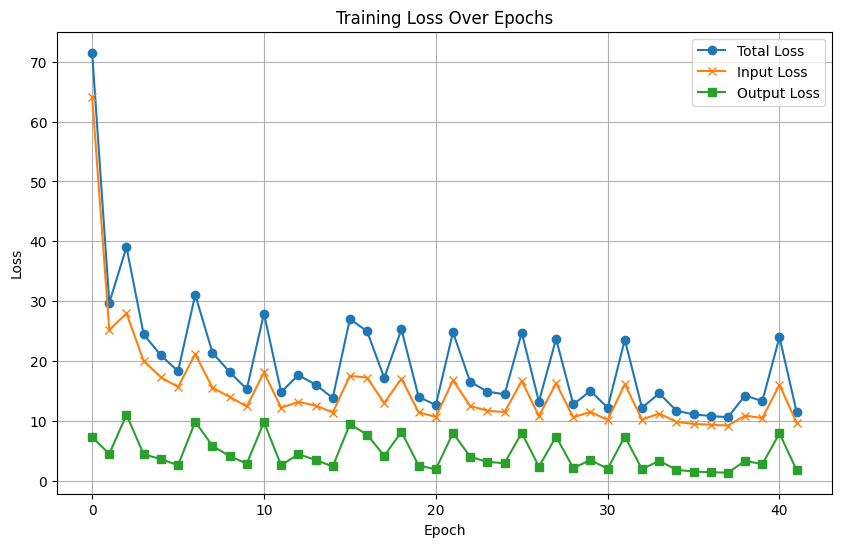

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(epoch_losses, label='Total Loss', marker='o')
plt.plot(epoch_input_losses, label='Input Loss', marker='x')
plt.plot(epoch_output_losses, label='Output Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# VERIFICATION

In [13]:
# Save the ATN in the newer `.keras` format for future compatibility

# Define model naming function
def generate_model_name(base_name, beta, epochs, structure):
    # Format the model name with hyperparameters
    return f"{base_name}_beta-{beta}_epochs-{epochs}_{structure}.keras"

# Specify model details
#base_name = "adversarial_transformation_network"

#structure = "conv2d_transpose"  # Example structure (descriptive)

# Generate the model name
#model_name = generate_model_name(base_name, beta, epochs, structure)
model_name='ATN_model/ATNMultuScale_Random_ATN2.keras'
# Save the ATN with the generated name
atn.save(model_name)
print(f"ATN saved successfully as {model_name}")



ATN saved successfully as ATN_model/ATNMultuCNN_ATN2.keras


In [ ]:
# Load Model


#loaded_atn_model = tf.keras.models.load_model('ATN_model/ATNPure.keras')

In [ ]:

import matplotlib.pyplot as plt







# Function to evaluate and compare results
def evaluate_atn(original_model, atn, dataset):
    for x_batch, y_original_batch in dataset.take(1):  # Take one batch (two elements per batch in the dataset)
        # Generate transformed images
        x_transformed = atn.predict(x_batch)

        # Get predictions for the original and transformed images
        y_pred_original = tf.argmax(original_model.predict(x_batch), axis=1)
        y_pred_transformed = tf.argmax(original_model.predict(x_transformed), axis=1)

        # Get true labels
        y_true = tf.argmax(y_original_batch, axis=1)

        # Print results for comparison
        print("True Labels:", y_true.numpy())
        print("Original Predictions:", y_pred_original.numpy())
        print("Transformed Predictions:", y_pred_transformed.numpy())

        # Display images
        display_images(x_batch, x_transformed, y_true, y_pred_original, y_pred_transformed, original_model.predict(x_batch))
        break  # Only evaluate one batch for now

# Function to display images
def display_images(original_images, transformed_images, y_true, y_pred_original, y_pred_transformed, original_pred):
    num_images = min(10, len(original_images))  # Display up to 10 images
    plt.figure(figsize=(15, 5))

    for i in range(num_images):
        # Original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(tf.squeeze(original_images[i]), cmap='gray')  # Remove channel for grayscale display
        plt.title(f"Label: {y_true[i].numpy()}, \n Pred: {y_pred_original[i].numpy()}")
        plt.axis('off')

        # Transformed image
        second_highest_target = get_second_highest_target(original_pred[i: i + 1])[0]  # Compute target dynamically
        second_highest_class = tf.argmax(second_highest_target).numpy()

        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(tf.squeeze(transformed_images[i]), cmap='gray')
        plt.title(f"Target: {second_highest_class}, \n Pred: {y_pred_transformed[i].numpy()}")
        plt.axis('off')

    plt.show()


# Evaluate the ATN on the test dataset
evaluate_atn(original_model, atn, mnist_test_atn)


In [ ]:
# Function to calculate accuracy
def calculate_accuracy(model, dataset, atn=None):
    correct = 0
    total = 0

    for x_batch, y_original_batch in dataset:  # Only unpack two elements
        if atn:
            # Transform images using ATN
            x_batch = atn.predict(x_batch, verbose=0)  # Suppress verbose output
        # Get predictions from the model
        y_pred = tf.argmax(model.predict(x_batch, verbose=0), axis=1)
        y_true = tf.argmax(y_original_batch, axis=1)  # True labels
        # Count correct predictions
        correct += tf.reduce_sum(tf.cast(y_pred == y_true, tf.float32)).numpy()
        total += x_batch.shape[0]  # Batch size
    
    return correct / total  # Calculate accuracy


# Original accuracy
original_accuracy = calculate_accuracy(original_model, mnist_test_atn, atn=None)
print(f"Accuracy on original images: {original_accuracy:.4f}")

# Transformed accuracy
transformed_accuracy = calculate_accuracy(original_model, mnist_test_atn, atn=atn)
print(f"Accuracy on transformed images: {transformed_accuracy:.4f}")
